## Fine tuning model to recognize opened or closed window
Use cases: check if windows are closed if raining or when leaving house


In [33]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
# libraries for displaying images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import math
from skimage import exposure
from tensorflow.keras.callbacks import CSVLogger

In [34]:
# # Perform all installations
# !pip install tensorflow-gpu==2.5.0
# !pip install tensorflow-datasets
# !pip install tensorwatch
# import tensorflow_datasets as tfds

# tfds makes a lot of progress bars and they take up a lot of screen space, so lets diable them
# tfds.disable_progress_bar()



In [35]:
WIDTH = 224
HEIGHT = 224
NUM_CLASSES = 2
TRAIN_DATA_DIR = r"../contents/windows_imgs/train"
VAL_DATA_DIR = r"../contents/windows_imgs/val"
DATA_DIR = r"../contents/windows_imgs/data"
TEST_DATA_DIR = r"../contents/windows_imgs/test"
LOG_DIR = './log'
TRAIN_SAMPLES = 9
VAL_SAMPLES = 4
BATCH_SIZE = 64
EPOCH = 100
CLASS_THRESHOLD = 0.3
LEARNING_RATE = 0.001

from datetime import datetime
ts = datetime.now()
ts = f"{ts:%Y%m%d-%H%M%S}"


### Prepare the data
load image data from directory and preprocess it

In [36]:

from numpy import left_shift, right_shift


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range=0.1,
    fill_mode = 'nearest',
    # brightness_range=(0.8,1.2),
    # shear_range=0.2,
    # featurewise_center =True,
    # horizontal_flip=True,
    # validation_split=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [37]:

train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 12345,
    class_mode = 'binary',
    # subset='training',
    save_to_dir=r"../contents/windows_imgs/output/train/",
    save_prefix="",
    save_format='jpg')
TRAIN_SAMPLES = train_generator.samples

val_generator = val_datagen.flow_from_directory(
    VAL_DATA_DIR,
    target_size=(WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    shuffle = False,
    class_mode = 'binary',
    # subset='validation',
    save_to_dir=r"../contents/windows_imgs/output/val/",
    save_prefix="",
    save_format='jpg')
VAL_SAMPLES = val_generator.samples


Found 141 images belonging to 2 classes.
Found 31 images belonging to 2 classes.


Code to show the augmented images

In [38]:
# # define the figure plot area
# # fig, ax = plt.subplots(1,NUM_IMG, figsize=(12,4))
# import matplotlib.pyplot as plt

# for i in range(BATCH_SIZE):
#     print(f'Run #{i}')
#     img, label = train_generator.next()
#     # classval = np.argmax(label[0], axis = 0)    # convert one-hot encoding to index
#     # classkey = find_key(classval, iter_img.class_indices) # get class key from index value
#     plt.imshow(img[0])
#     plt.show()
#     # print(f'img shape {img.shape}')
#     # print(f'img label {classkey}\n')

# plt.show()

In [39]:
# import cv2

# # cv2.waitKey(0)
# cam = cv2.VideoCapture(0)

# result, cam_img = cam.read()
# if result:
#     # cv2.imshow("Captured image", cam_img)
#     cv2.imwrite(TEST_DATA_DIR + r"\test_window.jpeg", cam_img)
#     # cv2.waitKey(0)
#     # cv2.destroyAllWindows()
# else:
#     print("No image detected. Please try again.") 


# from sympy import plot


# img_path = r'../contents/windows_imgs/test/test_window.jpeg'
# img = image.load_img(img_path, target_size=(224, 224))
# img_array = image.img_to_array(img)
# expanded_img_array = np.expand_dims(img_array, axis=0)
# preprocessed_img = expanded_img_array / 255.  # Preprocess the image
# prediction = model.predict(preprocessed_img)
# print(prediction)
# print(val_generator.class_indices)

# # plt.figure(1,1)
# plt.imshow(img)
# plt.show()

#### Load the pre-trained modfel and add in fine tuning layers
Now we define the model layers to freeze, discard to classification layers
then finally add in the fine tuning layers


In [40]:

def model_maker():
    # load model
    base_model = MobileNet(
        include_top=False,
        input_shape=(WIDTH, HEIGHT,3))
    for layer in base_model.layers[:]:
        layer.trainable = False
    input = Input(shape=(WIDTH, HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    # custom_model = Flatten()(custom_model)
    custom_model = Dense(256, activation = 'sigmoid')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(1, activation='sigmoid')(custom_model)
    return Model(inputs=input, outputs=predictions)


Just trying out with another pre-trained model

In [41]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2


def model_maker_inceptionResNetV2():
    # load model
    base_model = InceptionResNetV2(
        include_top=False,
        input_shape=(WIDTH, HEIGHT,3))
    for layer in base_model.layers[:]:
        layer.trainable = False
    input = Input(shape=(WIDTH, HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Flatten()(custom_model)
    custom_model = Dense(256, activation = 'relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(1, activation='sigmoid')(custom_model)
    return Model(inputs=input, outputs=predictions)


Testing with another model from scratch, however it perform poorly. I am not sure why

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
# from tensorflow.keras.optimizers import SGD,RMSprop,adam

def model_maker_scratch():
    from_scratch = Sequential()
    from_scratch.add(Convolution2D(224, 3,3,input_shape=(WIDTH, HEIGHT, 3)))
    from_scratch.add(Activation('relu'))
    from_scratch.add(Convolution2D(1000, 3, 3))
    from_scratch.add(Activation('relu'))
    from_scratch.add(MaxPooling2D(pool_size=(2, 2)))
    from_scratch.add(Dropout(0.5))
    # from_scratch.add(Convolution2D(64, 3, 3))
    from_scratch.add(Convolution2D(1000, 3, 3))
    from_scratch.add(Activation('relu'))
    from_scratch.add(MaxPooling2D(pool_size=(2, 2)))
    from_scratch.add(Dropout(0.5))
    # 

    from_scratch.add(Dense(256, activation='relu'))
    from_scratch.add(Dropout(0.5))
    from_scratch.add(Dense(1, activation='sigmoid'))
    # from_scratch.add(Dense(1))
    # from_scratch.add(Activation('sigmoid'))
    return(from_scratch)


In [43]:
# switch between models
# model = model_maker_scratch()
# model = model_maker_inceptionResNetV2()
model = model_maker()

model.compile(
    loss = 'binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    metrics=['accuracy'])

model.summary()

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta=0.001, patience=3)

#Allow TensorBoard callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(f"{LOG_DIR}\{ts}",
                                                      histogram_freq=1,
                                                      write_graph=True,
                                                      write_grads=True,
                                                      batch_size=BATCH_SIZE,
                                                      write_images=True)

csv_logger = CSVLogger('windows-training-' + 'log.csv',
                        append=True,
                        separator=';')



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_2  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257 

In [44]:

from gc import callbacks


history = model.fit(
    train_generator,
    steps_per_epoch=math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE),
    epochs=EPOCH,
    callbacks=[tensorboard_callback,csv_logger,early_stopping],
    validation_data=val_generator,
    validation_steps=math.ceil(float(VAL_SAMPLES)/BATCH_SIZE))
    

Epoch 1/100
3/3 [==============================] - 10s 4s/step - loss: 0.8598 - accuracy: 0.5887 - val_loss: 0.7031 - val_accuracy: 0.5161
Epoch 2/100
3/3 [==============================] - 7s 2s/step - loss: 0.7393 - accuracy: 0.5177 - val_loss: 0.7169 - val_accuracy: 0.5161
Epoch 3/100
3/3 [==============================] - 8s 2s/step - loss: 0.6769 - accuracy: 0.5887 - val_loss: 0.7316 - val_accuracy: 0.5161
Epoch 4/100
3/3 [==============================] - 7s 3s/step - loss: 0.6946 - accuracy: 0.6312 - val_loss: 0.6934 - val_accuracy: 0.5806
Epoch 5/100
3/3 [==============================] - 8s 3s/step - loss: 0.6665 - accuracy: 0.6525 - val_loss: 0.6745 - val_accuracy: 0.5806
Epoch 6/100
3/3 [==============================] - 8s 3s/step - loss: 0.6242 - accuracy: 0.6525 - val_loss: 0.6603 - val_accuracy: 0.5806
Epoch 7/100
3/3 [==============================] - 8s 3s/step - loss: 0.6381 - accuracy: 0.6879 - val_loss: 0.6399 - val_accuracy: 0.7742
Epoch 8/100
3/3 [================

In [45]:
# Start TensorBoard
%tensorboard --logdir ./log

Reusing TensorBoard on port 6006 (pid 41488), started 1 day, 23:45:20 ago. (Use '!kill 41488' to kill it.)

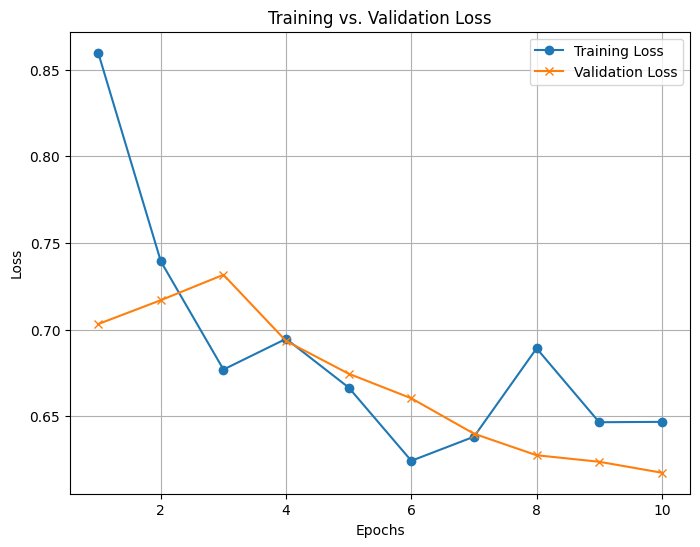

In [46]:
import matplotlib.pyplot as plt

# Assuming you have a 'history' object with training and validation loss
# Example: history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

# Retrieve training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='x')

# Customize the plot
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [47]:
h5_path = f'..\contents\models\winclass_{ts}.h5'
model.save(h5_path)
tf.saved_model.save(model, "tmp/model/1/")

import shutil

# Specify the file you want to copy
source_file = h5_path
destination_file = 'model.h5'

# Copy the file
shutil.copyfile(source_file, destination_file)

print(f"File copied successfully from {source_file} to {destination_file}")

C:\Users\I15674834\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: tmp/model/1/assets


INFO:tensorflow:Assets written to: tmp/model/1/assets


File copied successfully from ..\contents\models\winclass_20240409-123216.h5 to model.h5


In [48]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

model = load_model('model.h5')

In [ ]:
import cv2

# cv2.waitKey(0)
cam = cv2.VideoCapture(0)

result, cam_img = cam.read()
if result:
    
    # cv2.imshow("Captured image", cam_img)
    # equ_img = cv2.equalizeHist(cam_img)
    cv2.imwrite(TEST_DATA_DIR + r"\test_window.jpeg", cam_img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
else:
    print("No image detected. Please try again.") 

from skimage import exposure, transform
from skimage.io import imread

img_path = r'../contents/windows_imgs/test/test_window.jpeg'
img = image.load_img(img_path, target_size=(224, 224))

# img = imread(img_path)
# img = exposure.equalize_hist(img)
# new_shape = (224, 224)
# img = transform.resize(img, new_shape, anti_aliasing=True)

img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = expanded_img_array / 255.  # Preprocess the image
prediction = model.predict(preprocessed_img)
print(prediction)
print(val_generator.class_indices)

# plt.figure(1,1)
plt.title(f"File Name: {img_path}, \n Prediction: Window is  {'Close' if prediction < CLASS_THRESHOLD else 'Open'}")
plt.imshow(img)
plt.show()    


## List all images in test folder and make predictions

In [51]:
import os
filelist = os.listdir(VAL_DATA_DIR + r"/close/")
# filelist = os.listdir(TEST_DATA_DIR)
jpegfiles = [file for file in filelist if file.endswith('.jpeg')]


Wanted to shrink the images down and display it inside a grid here.. work in progress

In [52]:
# ## loop through file list and make a grid of images
# cols = 3
# rows = -(-jpegfiles.count // cols)
# fig, axes = plt.subplot(3, rows, figsize(18,6))
# axes = axes.flatten()

# # Plot each image in the corresponding subplot
# for i, image in enumerate(images):
#     img = image.load_img(os.path.join(VAL_DATA_DIR  + r"/close/",file), target_size=(WIDTH,HEIGHT))
#     # img = image.load_img(os.path.join(TEST_DATA_DIR,file), target_size=(WIDTH,HEIGHT))
#     img_array = image.img_to_array(img)
#     expanded_img_array = np.expand_dims(img_array, axis=0)
#     preprocessed_img = expanded_img_array / 255.  # Preprocess the image
#     prediction = model.predict(preprocessed_img)
#     print(prediction)
#     print(val_generator.class_indices)

#     ax = axes[i]
#     ax.imshow(img)
#     ax.title(f"File Name: {file}, \n Prediction: Window is  {'Close' if prediction < CLASS_THRESHOLD else 'Open'}")

#     ax.axis('off')  # Turn off axis labels

# plt.figure()

1/1 [==============================] - 0s 37ms/step
[[0.30040956]]
{'close': 0, 'open': 1}


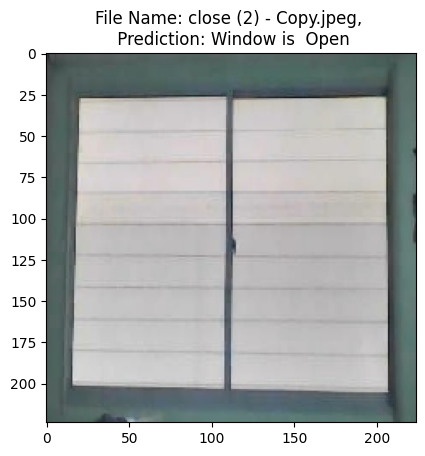

1/1 [==============================] - 0s 38ms/step
[[0.39282534]]
{'close': 0, 'open': 1}


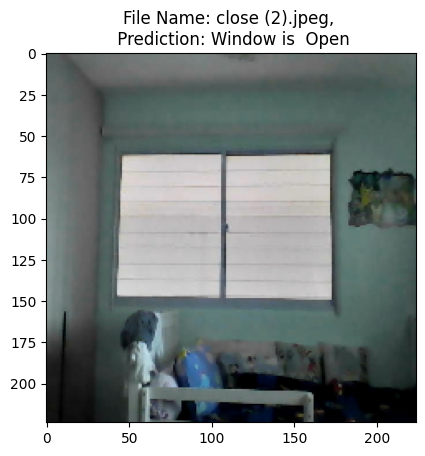

1/1 [==============================] - 0s 31ms/step
[[0.32650858]]
{'close': 0, 'open': 1}


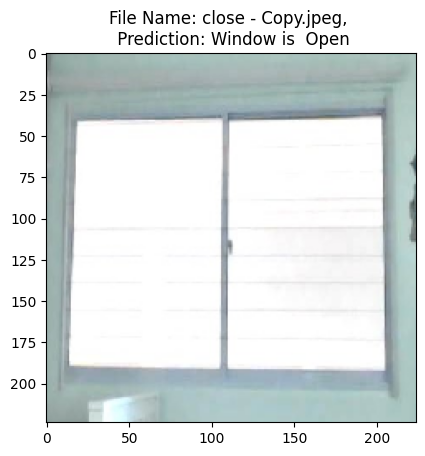

1/1 [==============================] - 0s 30ms/step
[[0.34329113]]
{'close': 0, 'open': 1}


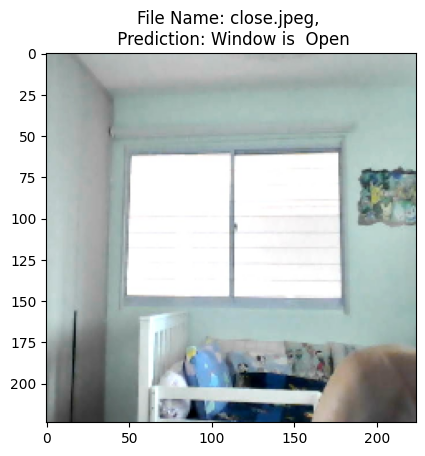

1/1 [==============================] - 0s 40ms/step
[[0.4614422]]
{'close': 0, 'open': 1}


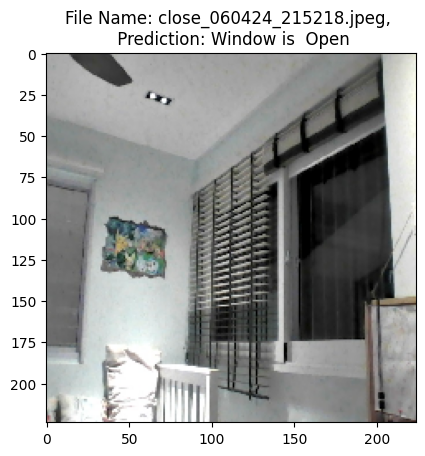

1/1 [==============================] - 0s 35ms/step
[[0.42325777]]
{'close': 0, 'open': 1}


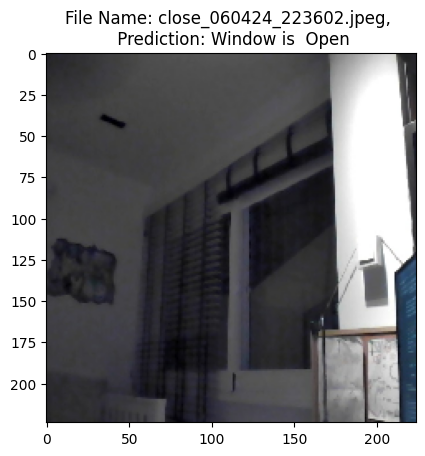

1/1 [==============================] - 0s 44ms/step
[[0.53579277]]
{'close': 0, 'open': 1}


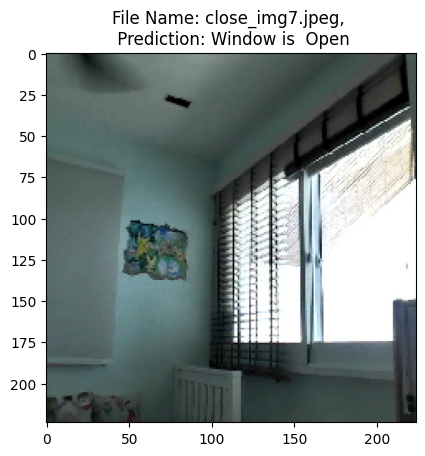

1/1 [==============================] - 0s 32ms/step
[[0.48833418]]
{'close': 0, 'open': 1}


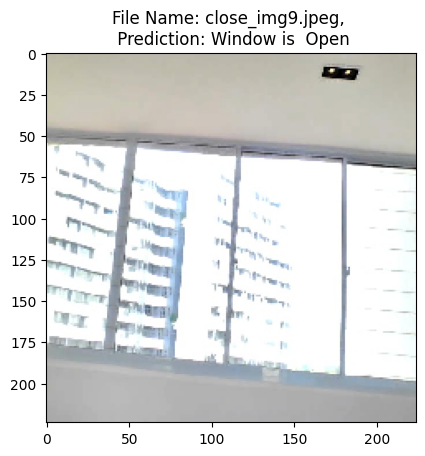

1/1 [==============================] - 0s 35ms/step
[[0.43867677]]
{'close': 0, 'open': 1}


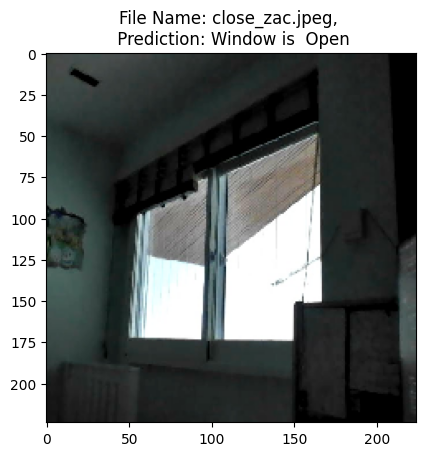

1/1 [==============================] - 0s 38ms/step
[[0.4421171]]
{'close': 0, 'open': 1}


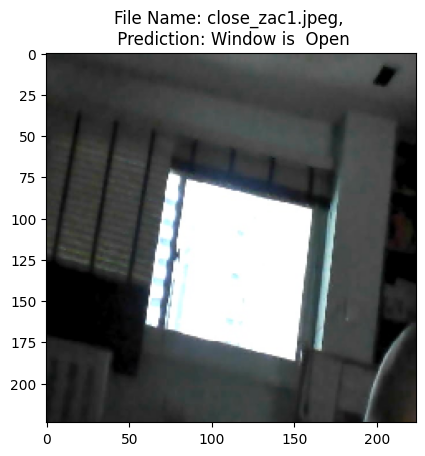

1/1 [==============================] - 0s 47ms/step
[[0.3117463]]
{'close': 0, 'open': 1}


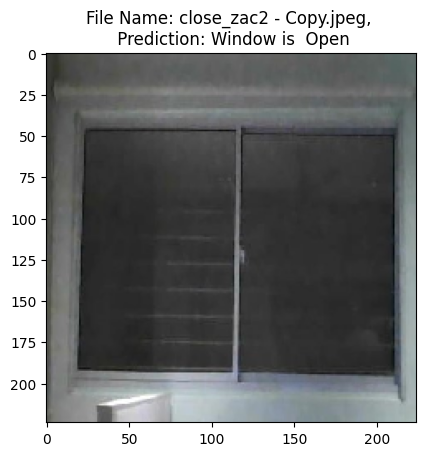

1/1 [==============================] - 0s 36ms/step
[[0.41066632]]
{'close': 0, 'open': 1}


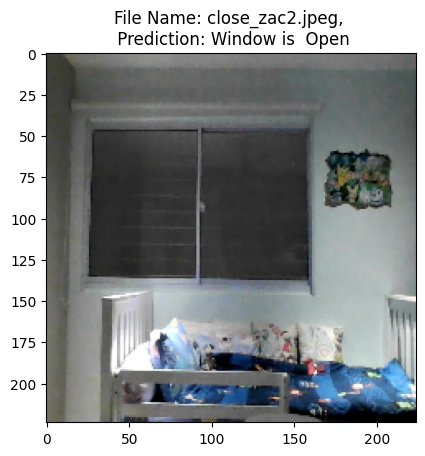

1/1 [==============================] - 0s 63ms/step
[[0.41426113]]
{'close': 0, 'open': 1}


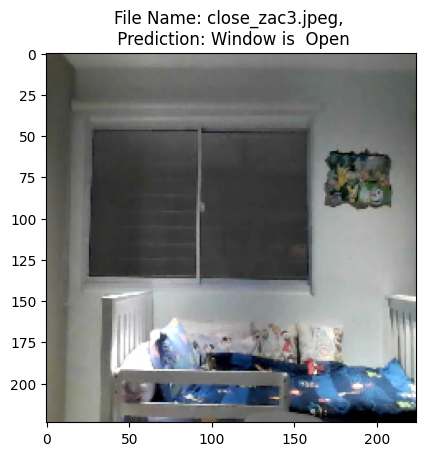

In [53]:
for file in jpegfiles:
    img = image.load_img(os.path.join(VAL_DATA_DIR  + r"/close/",file), target_size=(WIDTH,HEIGHT))
    # img = image.load_img(os.path.join(TEST_DATA_DIR,file), target_size=(WIDTH,HEIGHT))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = expanded_img_array / 255.  # Preprocess the image
    prediction = model.predict(preprocessed_img)
    print(prediction)
    print(val_generator.class_indices)

    plt.title(f"File Name: {file}, \n Prediction: Window is  {'Close' if prediction < CLASS_THRESHOLD else 'Open'}")
    plt.imshow(img)
    plt.show()    